In [77]:
from sdv.demo import load_timeseries_demo
import pandas as pd

In [78]:
data = pd.read_csv('./AAPL Historical Data.csv')

In [103]:
data.head()

,Date,Price
0,11/01/2013,19.86
1,12/01/2013,20.04
2,01/01/2014,17.88
3,02/01/2014,18.79
4,03/01/2014,19.17


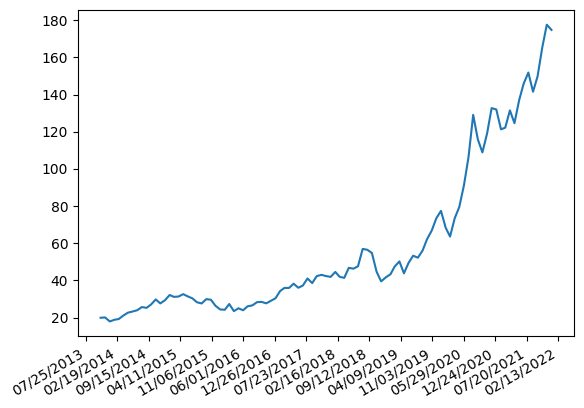

In [113]:
import matplotlib as plt
dates = list(data['Date'])
import datetime as dt
x = [dt.datetime.strptime(d,'%m/%d/%Y').date() for d in dates]
y = list(data['Price'])

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval = 5000))
plt.plot(x,y)
plt.gcf().autofmt_xdate()
plt.show()

In [104]:
from sdv.timeseries import PAR


In [117]:
model = PAR(
  )

In [118]:
model.fit(data)

In [119]:
data_new = model.sample()
data_new.head()

,Date,Price
0,02/01/2017,47.204676
1,01/01/2015,42.563749
2,05/01/2016,35.517645
3,12/01/2014,27.947970
4,08/01/2015,29.512086


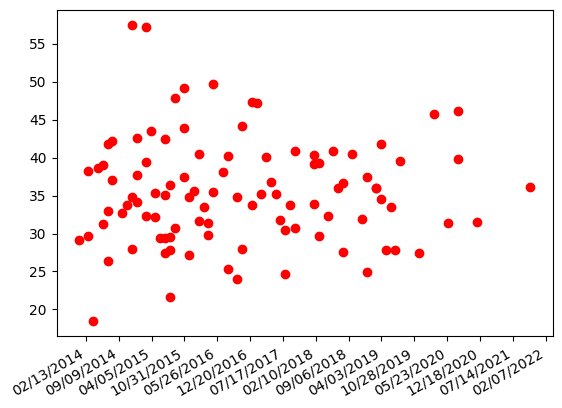

In [120]:
import matplotlib as plt
dates = list(data_new['Date'])
import datetime as dt
x = [dt.datetime.strptime(d,'%m/%d/%Y').date() for d in dates]
y = list(data_new['Price'])

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval = 5000))
plt.plot(x,y)
plt.gcf().autofmt_xdate()
plt.show()